# Whole city count prediction 

# TODO: INCREMENTAL TRAINING EVALUATION LOOPS

In [1]:
from utils.plots import plot, displot
from seaborn import distplot
import matplotlib.pyplot as plt
from models.baseline_models import historic_average

import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN, evaluate_fnn
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_results, save_metrics, \
    compare_all_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths, by_ref
from trainers.generic_trainer import train_model

from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from time import time
from torch.optim import lr_scheduler

from pprint import pprint
import logging

from matplotlib import rcParams
from utils.forecasting import compare_time_series_metrics

from utils.utils import load_total_counts, to_title, set_system_seed
from utils.data_processing import normalize_df_mean_std, normalize_df_min_max
from utils.plots import plot, plot_df, plot_time_signals, plot_autocorr

from utils.forecasting import forecast_metrics

from models.sequence_models import train_epoch_for_sequence_model, evaluate_sequence_model
import plotly.graph_objects as go

import pingouin as pg # used to allow partial correlation of dataframes

from trainers.generic_trainer import train_model_final

os.environ['NUMEXPR_MAX_THREADS'] = str(os.cpu_count())
rcParams["font.family"] = "STIXGeneral"


import plotly.io as pio


# ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]
pio.templates.default = "plotly_white" # "none"

In [2]:
from datasets.sequence_dataset import SequenceDataLoaders
from models.rnn_models import GRUFNN

In [3]:
data_sub_paths = [i for i in get_data_sub_paths() if i.startswith('Totals')]
data_sub_paths

['Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525',
 'Totals_T168H_2001-01-04_2019-01-10_LAT41.641_42.024_LON-87.821_-87.525',
 'Totals_T1H_2014-01-01_2019-01-01_LAT41.641_42.024_LON-87.821_-87.525']

In [4]:
data_sub_path = data_sub_paths[0]
save_folder = f"./data/processed/{data_sub_path}/plots/"
os.makedirs(save_folder, exist_ok=True)
FREQ = data_sub_path.lstrip('Totals_T').split('_')[0]
time_steps_per_day = 24/int(FREQ[:-1])

freq_title = {
    "24H":"Daily",
    "1H": "Hourly",
    "168H":"Weekly",
}.get(FREQ, "Hourly")
print(f"Using: {freq_title} ({FREQ})")

Using: Daily (24H)


In [5]:
df = load_total_counts(folder_name=data_sub_path)
display(df)

Total  Theft  Battery  Criminal Damage  Narcotics  Assault  \
2001-01-01   1253    400      292              232         96       70   
2001-01-02    884    218      142              118        175       65   
2001-01-03    910    222      163              136        133       79   
2001-01-04    939    241      172              132        142       57   
2001-01-05   1020    260      177              138        185       67   
...           ...    ...      ...              ...        ...      ...   
2018-12-27    469    157       90               65         26       43   
2018-12-28    547    177      114               62         53       46   
2018-12-29    535    132      139               83         38       50   
2018-12-30    530    133      134               83         32       47   
2018-12-31    506    153      105               93         21       41   

            Burglary  Motor Vehicle Theft  Robbery  
2001-01-01        65                   58       40  
2001-01-02        68                   64       34  
2001-01-03        57                   69       51  
2001-01-04        53                   87       55  
2001-01-05        55                   83       55  
...              ...                  ...      ...  
2018-12-27        33                   28       27  
2018-12-28        32                   25       38  
2018-12-29        35                   28       30  
2018-12-30        31                   32       38  
2018-12-31        29                   25       39  

[6574 rows x 9 columns]

In [46]:
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())
else:
    raise Exception("CUDA is not available")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [50]:
torch.randn(1,86).to(conf.device)

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [7]:
# manually set
conf = BaseConf()
conf.seed = int(time()) # 3
set_system_seed(conf.seed)
conf.model_name = f"{freq_title} City Count" # "SimpleKangFNN" # "KangFNN"  # needs to be created
conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

# SET THE HYPER PARAMETERS
conf.shaper_top_k = -1
conf.use_classification = False
conf.train_set_first = True
conf.use_crime_types = False

2021-01-23T15:50:06 | root | INFO | =====================================BEGIN=====================================
2021-01-23T15:50:06 | root | INFO | Device: cuda:0


# Determine the total crime counts in the next time step

### Anomaly Detection Plots

In [8]:
from utils.mutual_information_plots import subplot_mi_curves, plot_mi_curves
from utils.data_processing import to_percentile
from utils.rolling import rolling_norm, flag_anomalies, periodic_rolling_mean

plot_anomalies = False
if plot_anomalies:
    window =51
    period = {
        "24H":7,
        "1H": 24,
        "168H":1,
    }.get(FREQ, 1)
    thresh = 3
    period = 1

    for col in df.columns:
        a = df[col].values

        anoms = flag_anomalies(
            data=a, thresh=thresh, window=window, period=period, center=True, mode='reflect')

        ma = periodic_rolling_mean(data=a, window=window, period=period, center=True)
        normed = rolling_norm(data=a, window=window, period=period, center=True)

        go.Figure(
            data=[
                go.Scatter(x=df.index,y=a,opacity=.5,name=f'Counts'),
                go.Scatter(x=df.index[anoms],y=a[anoms],mode='markers',opacity=.5, name='Outliers'),
                go.Scatter(x=df.index,y=ma,opacity=.5,name=f'MA'),
            ],
            layout=dict(
                title_text=col,
                title_x=0.5,
                font=dict(family="STIXGeneral"),
                yaxis_title="Counts",
                xaxis_title="Date Time",
            ),
        ).show()

### Mutual Information Plots

In [9]:
# from utils.plots import subplots_df, plot_df
# from utils.mutual_information_plots import plot_mi_curves
plot_mi_curves = False
if plot_mi_curves:
    temporal_variables = {
        "1H":["Hour", "Day of Week", "Time of Month", "Time of Year"],
        "24H":["Day of Week", "Time of Month", "Time of Year"],
        "168H":["Time of Month", "Time of Year"],
    }.get(FREQ, ["Time of Month", "Time of Year"])


    max_offset = {
        "1H":168*2,
        "24H":365,
        "168H":54,
    }.get(FREQ)


    for i, name in enumerate(df.columns):
        a = df[name].values
        
        mutual_info_bins = 16 # 16
#         print(f"optimal bins: {get_optimal_bins(a)}")
#         a = to_percentile(a)
#         a = np.round(np.log(1+a)) # whatch out for values between 1024 2048
#         a = cut(np.log(1+a)) # whatch out for values between 1024 2048
        
        fig = subplot_mi_curves(
            a=a,
            t_range=df.index,
            max_offset=max_offset,
            norm=True,
            log_norm=False,
            bins=mutual_info_bins,
            month_divisions=4,
            year_divisions=12,
            temporal_variables=temporal_variables,
            title=f'{freq_title} {name} Mutual and Conditional Mutual Information',
            a_title=f'{freq_title} {name} City Wide Counts',
        )
        fig.write_image(f"{save_folder}{FREQ}_{name}_mi_plots.png".replace(' ','_'))
        fig.show()

### Peridic Rolling Normilasation
By applying rolling normilation we can control for the period nature of our signals. We subtract the signal by a periodic rolling mean and divide it by a period rolling standard deviation. We can also perform this on various periods e.g. 7 days and 365 days, which caters for weekly and yearly periodic cycles. By controlling for the signals periodic nature we essentially have a new signal show casing how many standard deviations a current time step is outside of the expected value for that day of the week and time of the year. Our potential models then just need to predict the residuals of our crime signals.

In [10]:
# try and normalise rolling data to mitigate the trends
from utils.rolling import rolling_norm

# TODO: make use of RollingNormScaler instead?
normalize_periodically = True
if normalize_periodically: 
    logging.warning("Using rolling norm means values at the " + 
                    "start within the window will be set to NaN and dropped")
    
    
    max_offset = {
        "1H":168*2,
        "24H":365,
        "168H":54,
    }.get(FREQ)
    
    fig = plot_autocorr(**df,
                  title="Autocorrelations by Crime Type before any Rolling Normalisation",
                  partial=False,
                  max_offset=400)
    fig.write_image(f"{save_folder}{FREQ}_auto_corr_normed_none.png".replace(' ','_'))
    fig.show()
    
    window, period, period_string = {
        "24H": (10,7, "Weekly"),  # jumps in weeks
        "1H":  (10,24, "Daily"),  # jumps in days
        "168H": (10,1, "Weekly"),  # jumps in weeks
    }.get(FREQ, (10,1))
    logging.info(f"Using rolling norm window: {window} and period: {period}")
    
    normed_df = rolling_norm(data=df,window=window,period=period).dropna()
    fig = plot_autocorr(**normed_df,
              title=f"Autocorrelations by Crime Type after {period_string} Rolling Normalisation",
              max_offset=max_offset)
    fig.write_image(f"{save_folder}{FREQ}_auto_corr_normed_{period_string.lower()}.png".replace(' ','_'))
    fig.show()
    
    fig = plot_df(pd.DataFrame(df["Total"]),xlabel="Date",ylabel="Count",
            title=f"Total Crimes before any Rolling Normalisation")
    fig.write_image(f"{save_folder}{FREQ}_total_crimes_normed_none.png".replace(' ','_'))
    fig.show()
    
    fig = plot_df(pd.DataFrame(normed_df["Total"]),xlabel="Date",ylabel="Scaled Count",
            title=f"Total Crimes after {period_string} Rolling Normalisation")
    fig.write_image(f"{save_folder}{FREQ}_total_crimes_normed_{period_string.lower()}.png".replace(' ','_'))
    fig.show()
    
    double_rolling_norm = True
    if double_rolling_norm:
        window2, period2, period_string2 = {
            "24H": (10,365, "Yearly"),  # jumps in years
            "1H":  (10,168, "Weekly"),  # jumps in weeks
            "168H": (5,52,"Yearly"),  # no years
        }.get(FREQ, (None,None,None))
        logging.info(f"Using second rolling norm window: {window2} and period: {period2}")

        if period_string2:
            # double norming takes out other periodic signals as well
            normed_df = rolling_norm(data=normed_df,window=window2,period=period2).dropna()  

            fig = plot_autocorr(**normed_df,
                  title=f"Autocorrelations by Crime Type after {period_string} and" + 
                                f" {period_string2} Rolling Normalisation",
                  max_offset=max_offset)
            fig.write_image(f"{save_folder}{FREQ}_auto_corr_normed_{period_string.lower()}_" + 
                            f"{period_string2.lower()}.png".replace(' ','_'))
            fig.show()

            fig = plot_df(pd.DataFrame(normed_df["Total"]),xlabel="Date",ylabel="Scaled Count",
                    title=f"Total Crimes after {period_string} and" + 
                                        f" {period_string2} Rolling Normalisation")
            fig.write_image(f"{save_folder}{FREQ}_total_crimes_normed_{period_string.lower()}_" + 
                            f"{period_string2.lower()}.png".replace(' ','_'))
            fig.show()

2021-01-23T15:50:08 | root | WARNING | Using rolling norm means values at the start within the window will be set to NaN and dropped


2021-01-23T15:50:09 | root | INFO | Using rolling norm window: 10 and period: 7


2021-01-23T15:50:13 | root | INFO | Using second rolling norm window: 10 and period: 365


In [11]:
# # Min Max Scale vectors
# from utils.data_processing import DataFrameMinMaxScaler
# scaler = DataFrameMinMaxScaler(minimum=0, maximum=1, axis=0) # allows us to rescale the results afterwards
# # total_df = scaler.fit_transform(df)
# total_df = scaler.fit_transform(normed_df)

# display(total_df)

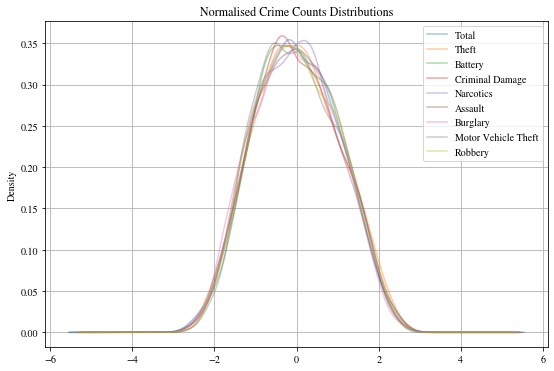

Total     Theft   Battery  Criminal Damage  Narcotics  \
2010-03-03  0.908408 -0.816207  1.409957         2.097224   0.472041   
2010-03-04  0.712898 -1.360844  1.330046         1.198030  -0.153649   
2010-03-05 -0.022051  0.012188 -0.332562         0.156093   0.262138   
2010-03-06  0.390954 -0.769355  0.677906         0.665363   1.095364   
2010-03-07  0.439415  0.747641  0.886502         0.136326   1.596505   
...              ...       ...       ...              ...        ...   
2018-12-27  0.047765  0.934395 -0.572955         0.415421  -0.154078   
2018-12-28 -0.772803 -0.191329 -0.530340        -0.558643   1.768477   
2018-12-29  1.190485 -1.283978  0.660517         1.327472   1.578123   
2018-12-30  0.400772 -0.324459 -0.629193         0.869430   1.381311   
2018-12-31  0.091591  0.248835 -0.675762         0.788436  -0.615313   

             Assault  Burglary  Motor Vehicle Theft   Robbery  
2010-03-03  1.152114  0.858516            -1.186239 -1.218051  
2010-03-04  0.823947 -0.829613            -1.223248  0.811179  
2010-03-05  0.630690 -0.115806            -0.627749 -0.865613  
2010-03-06 -0.491912  0.576681            -2.216592 -0.186637  
2010-03-07 -0.229988 -1.279521            -0.691929 -0.731636  
...              ...       ...                  ...       ...  
2018-12-27 -0.655580  0.815916            -0.228717  0.776051  
2018-12-28 -0.358057  0.055362            -1.649328  1.132238  
2018-12-29  1.599488  2.405093            -0.300109  0.224678  
2018-12-30  0.520217  2.547979             0.841852  1.976818  
2018-12-31 -0.939840  0.545853             0.015968  1.997745  

[3226 rows x 9 columns]

In [12]:
# total_df = normalize_df_min_max(normed_df) # rescale between 0 and 1 again...is this realy needed?
# total_df = normalize_df_mean_std(normed_df) # rescale between 0 and 1 again...is this realy needed?
total_df = normed_df
# total_df = df
# total_df = normalize_df_min_max(df)
# total_df = normalize_df_mean_std(df)
total_df.plot(kind='kde',alpha=0.4,title='Normalised Crime Counts Distributions')
fig = plt.gcf()
fig.set_size_inches(9,6)
plt.grid()
plt.show()
display(total_df)

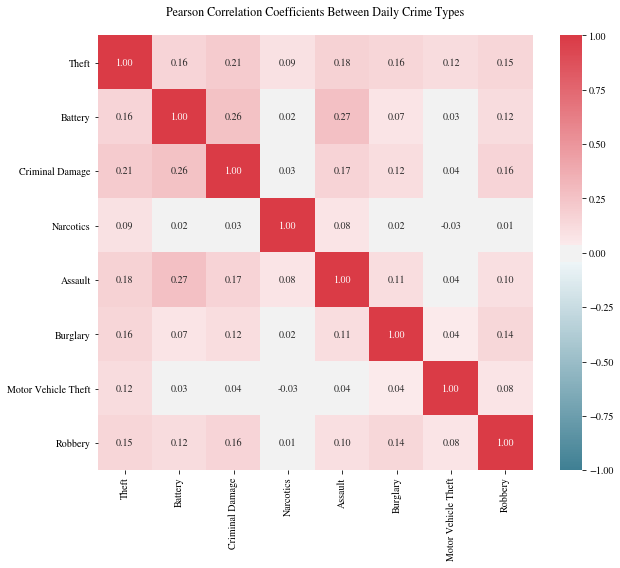

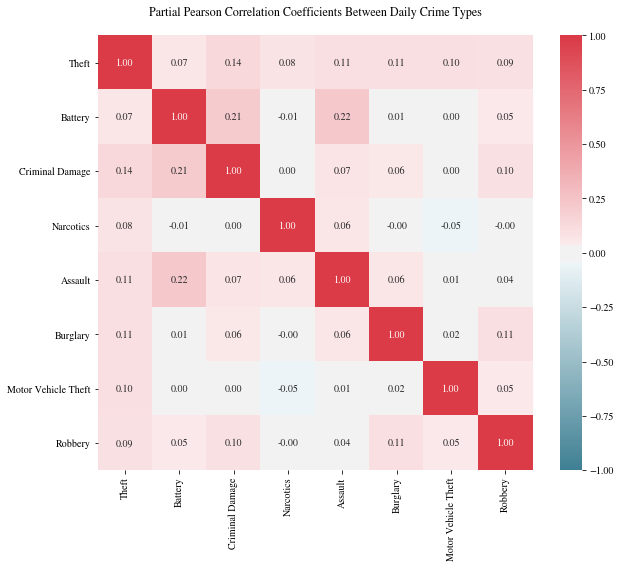

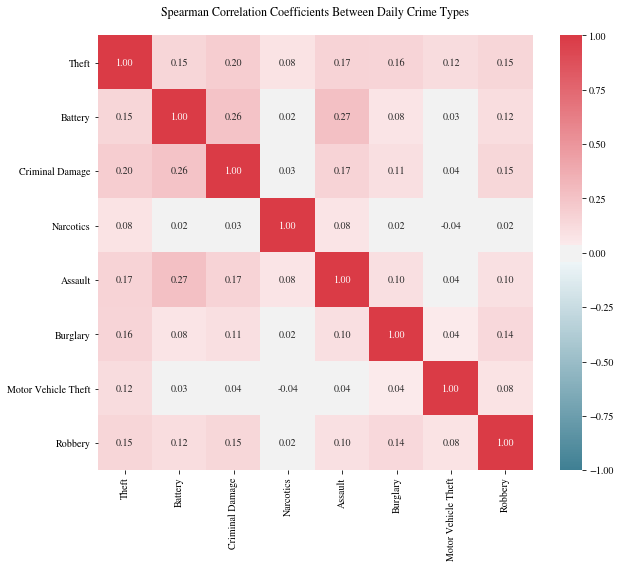

In [13]:
from utils.plots import plot_corr

corr = total_df.loc[:, total_df.columns != 'Total'].corr()
plot_corr(corr, title=f'Pearson Correlation Coefficients Between {freq_title} Crime Types\n')
plt.savefig(f"{save_folder}{FREQ}_corr_matrix_pearson.png")

corr = total_df.loc[:, total_df.columns != 'Total'].pcorr()
plot_corr(corr, title=f'Partial Pearson Correlation Coefficients Between {freq_title} Crime Types\n')
plt.savefig(f"{save_folder}{FREQ}_corr_matrix_pearson_partial.png")

corr = total_df.loc[:, total_df.columns != 'Total'].corr(method='spearman')
plot_corr(corr, title=f'Spearman Correlation Coefficients Between {freq_title} Crime Types\n')
plt.savefig(f"{save_folder}{FREQ}_corr_matrix_spearman.png")

In [14]:
t_range = total_df.index[1:] # should be equal to the target times
total_crime_types = total_df.values

In [15]:
time_vectors = encode_time_vectors(t_range)

plot_time_vectors = False
if plot_time_vectors:  
    k = int(time_steps_per_day*365)
    tv, tr = time_vectors[:k], t_range[:k]

    t_vec_names = {
        "1H":['$H_{sin}$', '$H_{cos}$', '$DoW_{sin}$', '$DoW_{cos}$',
              '$ToM_{sin}$', '$ToM_{cos}$', '$ToY_{sin}$', '$ToY_{cos}$', '$Wkd$'],
        "24H": ['$DoW_{sin}$','$DoW_{cos}$', '$ToM_{sin}$',
               '$ToM_{cos}$', '$ToY_{sin}$','$ToY_{cos}$', '$Wknd$'],
        "168H":['$ToM_{sin}$','$ToM_{cos}$', '$ToY_{sin}$','$ToY_{cos}$'],
    }.get(FREQ)


    pio.templates.default = "plotly"
    fig = go.Figure(
        data=go.Heatmap(
            z=tv.T,
            y=t_vec_names,
            x=tr,
        ),
        layout=dict(
            title=f"Encoded Time Vectors on {freq_title} Level",
            title_x=0.5,
            xaxis_title="Date",
            yaxis_title="Encoded Vector Values",
            font=dict(family="STIXGeneral"),
        ),
    )
    fig.write_image(f"{save_folder}{FREQ}_time_vector_encoding.png")
    fig.show()
    pio.templates.default = "plotly_white"

In [16]:
# Crime Time Correlations maps how each crime type is correlated to 
# certain time variables like time of day or day of week

plot_crime_time_correlations = False
if plot_crime_time_correlations:  
    time_df = pd.DataFrame(data=time_vectors,
                 index=t_range,
                 columns=list(map(lambda s: s.replace('$','').replace('{','').replace('}',''), t_vec_names)))

    time_df['Weekend'] = time_df['Wknd']
    del time_df['Wknd']
    time_df['Day of Week'] = time_df.index.dayofweek
    time_df['Month'] = time_df.index.month
    time_df['Day of Month'] = time_df.index.day
    time_df['Day of Year'] = time_df.index.dayofyear
    time_df['Week of Year'] = time_df.index.weekofyear

    t_size = time_df.shape[1]
    
    crime_time_df = pd.concat((time_df,df.loc[:, total_df.columns != 'Total']),axis=1).dropna()
    corr = crime_time_df.corr().iloc[t_size:, :t_size]
    plot_corr(corr, title=f'Pearson Correlation Coefficients Between {freq_title} Crime' +
              ' Types and Time Variables\n')
    plt.show()
    corr = crime_time_df.pcorr().iloc[t_size:, :t_size]
    plot_corr(corr, title=f'Partial Pearson Correlation Coefficients Between {freq_title}' +
              ' Crime Types and Time Variables\n')
    plt.show()
    
    
    crime_time_df = pd.concat((time_df,total_df.loc[:, total_df.columns != 'Total']),axis=1).dropna()
    corr = crime_time_df.corr().iloc[t_size:, :t_size]
    plot_corr(corr, title=f'Pearson Correlation Coefficients Between Normalised {freq_title} Crime ' + 
              'Types and Time Variables\n')
    plt.show()
    corr = crime_time_df.pcorr().iloc[t_size:, :t_size]
    plot_corr(corr, title=f'Partial Pearson Correlation Coefficients Between Normalised {freq_title}' +
              ' Crime Types and Time Variables\n')
    plt.show()    

### Setup Data Loaders 

In [17]:
# conf.seq_len = 60 # int(14*time_steps_per_day) + 1
conf.seq_len = {
    "24H": 90,
    "1H": 168,
    "168H": 52,
}.get(FREQ, 60)

conf.batch_size = 128

logging.info(f"Using sequence length: {conf.seq_len}")

input_data= total_crime_types[:-1] 

predict_only_total = True
if predict_only_total:
    target_data = total_crime_types[1:, 0:1] 
else:
    target_data = total_crime_types[1:]

assert len(input_data) == len(time_vectors), \
    f"len(input_data) != len(time_vectors), {len(input_data)},{len(time_vectors)}"

use_time_vectors = True
if use_time_vectors:
    logging.info("using time vectors in input")
    input_data = np.concatenate([input_data,time_vectors],axis=1)
else:
    logging.info("NOT using time vectors in input")


input_size = input_data.shape[-1]
output_size = target_data.shape[-1]

assert len(input_data) == len(t_range)

test_size = {
    "24H":365,
    "H": 8760,
    "1H":8760,
    "1W":52,
    "168H":52,
}.get(FREQ)

tst_ratio = test_size/len(input_data)

loaders = SequenceDataLoaders( # setup data loader 1
    input_data=input_data,
    target_data=target_data,
    t_range=t_range,
    batch_size=conf.batch_size,
    seq_len=conf.seq_len,
    shuffle=conf.shuffle,
    num_workers=0,
    val_ratio=0.5,
    tst_ratio=tst_ratio,
)

input_data.shape, target_data.shape

2021-01-23T15:50:17 | root | INFO | Using sequence length: 90
2021-01-23T15:50:17 | root | INFO | using time vectors in input


((3225, 16), (3225, 1))

In [18]:
# train evalute a 9 months at a time
len(loaders.test_loader.dataset) // 12

30

### Hyper-parameter Optimisation 

In [19]:
from utils.plots import plot_df

In [20]:
joint_df = pd.DataFrame({
    **{f"x_{i}": input_data[:,i] for i in range(input_data.shape[1])},
    **{f"y_{i}": target_data[:,i] for i in range(target_data.shape[1])},
}, index=t_range)

input_cols = [col for col in joint_df.columns if col.startswith('x')]
target_cols = [col for col in joint_df.columns if col.startswith('y')]

plot_df(joint_df[target_cols]).show()

'2010-09-05 00:00:00 -> 2010-09-06 00:00:00'

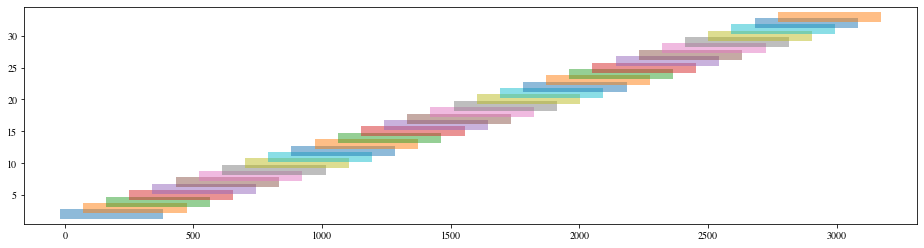


89
2010-09-05 00:00:00 -> 2011-03-03 00:00:00

89
2010-12-04 00:00:00 -> 2011-06-01 00:00:00

89
2011-03-04 00:00:00 -> 2011-08-30 00:00:00

89
2011-06-02 00:00:00 -> 2011-11-28 00:00:00


In [44]:
from dataloaders.indexers import WalkForwardIndexer

sub_tst_set_size = 90
sub_set_size = 365


indexer = WalkForwardIndexer(total_set_size=len(joint_df),
                             test_set_size=sub_tst_set_size,
                             sub_set_size=sub_set_size)

plt.figure(figsize=(16,4))
k = 0
for i, j in indexer:
    k += 1
    x = np.arange(i,j)
    y = np.ones_like(x) + k
    plt.plot(x,y,linewidth=10,alpha=.5)
plt.show()


# vaify that the index breaks sets into correct amounts
plot_list = []
set_no = 0
for i, j in indexer:
    if set_no > 3:
        break # only used for displaying purposes
    
    set_no += 1
    subset = joint_df[target_cols].iloc[i:j]
    plot_list.append(
        go.Scatter(name=f"set_{set_no}", y=subset.to_numpy().ravel()+3*set_no,x=subset.index,opacity=.5))
    
    sub_df = joint_df.iloc[i:j]
    loaders = SequenceDataLoaders( # setup data loader 2: hyper opt
        input_data=sub_df[input_cols].values,
        target_data=sub_df[target_cols].values,
        t_range=sub_df.index,
        batch_size=conf.batch_size,
        seq_len=conf.seq_len,
        shuffle=conf.shuffle,
        num_workers=0,
        val_ratio=0.2,
        tst_size=30*3,
    )
    
    print()
    print(f"{len(loaders.test_loader.dataset)}")
    print(f"{loaders.test_loader.dataset.t_range[0]} -> {loaders.test_loader.dataset.t_range[-1]}")
    

go.Figure(data=plot_list)

In [45]:
from pprint import pformat

def train_evaluate_hyper(hyper_parameters):
    logging.info(f"Running HyperOpt Trial with: {pformat(hyper_parameters)}")
    
    # hyper param setup
    hidden_size = hyper_parameters.get('hidden_size',50)
    num_layers = hyper_parameters.get('num_layers',5)
    conf.weight_decay = hyper_parameters.get('weight_decay', 1e-4)
    conf.lr = hyper_parameters.get('lr', 1e-3)

    default_seq_len = {
        "24H": 90,
        "1H": 168,
        "168H": 52,
    }.get(FREQ, 60)
    conf.seq_len = hyper_parameters.get('seq_len', default_seq_len)

    conf.early_stopping = True
    conf.patience = 30
    conf.min_epochs = 1
    conf.max_epochs = 15000
    
    set_system_seed(int(time())) # should be reset with each model instatiation
    
    loaders = SequenceDataLoaders( # setup data loader 2: hyper opt
        input_data=input_data,
        target_data=target_data,
        t_range=t_range,
        batch_size=conf.batch_size,
        seq_len=conf.seq_len,
        shuffle=conf.shuffle,
        num_workers=0,
        val_ratio=0.5,
        tst_ratio=tst_ratio,
    )    
    
    # model setup
    model = GRUFNN(
        input_size=input_size,
        hidden_size0=hidden_size, 
        hidden_size1=hidden_size//2, 
        output_size=output_size,
        num_layers=num_layers,
    ).to(conf.device)

    criterion = nn.MSELoss()
    optimiser = torch.optim.AdamW(params=model.parameters(),lr=conf.lr, weight_decay=conf.weight_decay)

    # training
    trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
        model=model,
        optimiser=optimiser,
        loaders=loaders,
        train_epoch_fn=train_epoch_for_sequence_model,
        loss_fn=criterion,
        conf=conf,
        verbose=False,
    )
    
    # load the saved best validation model
    # Load latest or best validation model
    conf.checkpoint = "best_val"
    log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")
    log.info(f"Loading model from {conf.model_path}")
    model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                  map_location=conf.device.type)
    model.load_state_dict(model_state_dict)
    
    # evaluation
    val_y_true, val_y_score = evaluate_sequence_model(model, loaders.validation_loader, conf)
    
    return forecast_metrics(y_true=val_y_true, y_score=val_y_score)['MASE']

optimize_hyper_params = True
if optimize_hyper_params:
    # Hyper Opt Training

    from ax.plot.contour import plot_contour
    from ax.plot.trace import optimization_trace_single_method
    from ax.service.managed_loop import optimize
    from ax.utils.notebook.plotting import render, init_notebook_plotting
    from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN

    # PARAM_CLASSES = ["range", "choice", "fixed"]
    # PARAM_TYPES = {"int": int, "float": float, "bool": bool, "str": str}
    # potential parameters
    hyper_params = [
        {"name": "lr", "type": "range", "bounds": [1e-6, 1e-2], "log_scale": True},
        {"name": "weight_decay", "type": "range", "bounds": [1e-8, 1e-2], "log_scale": True},    
        {"name": "hidden_size", "type": "choice", "values": [8,16,32,64,128]},
        {"name": "num_layers", "type": "choice", "values": [1,2,4,8]},
        {"name": "seq_len", "type": "choice", "values": [7,24,64,128]},
    ]

    best_parameters, values, experiment, model = optimize(
        parameters=hyper_params,
        evaluation_function=train_evaluate_hyper,
        objective_name='MASE',
        minimize=True, # change when the objective is a loss
        total_trials=3,
    #     random_seed=1, # optional
    )

    experiment_data = experiment.fetch_data()
    display(experiment_data.df)
    display(pd.DataFrame([best_parameters]))
    
#     render(plot_contour(model=model, param_x='lr', param_y='weight_decay', metric_name='MASE'))

[INFO 01-23 18:02:11] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 01-23 18:02:11] ax.service.managed_loop: Started full optimization with 3 steps.
[INFO 01-23 18:02:11] ax.service.managed_loop: Running optimization trial 1...


2021-01-23T18:02:11 | root | INFO | Running HyperOpt Trial with: {'hidden_size': 16,
 'lr': 0.0008525991763248243,
 'num_layers': 8,
 'seq_len': 7,
 'weight_decay': 0.005238002927434273}
2021-01-23T18:02:11 | root | INFO | Set system seed to 1611417731


RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [57]:
display(pd.DataFrame([best_parameters]).iloc[0])

lr              1.032892e-03
weight_decay    9.688213e-07
hidden_size     1.280000e+02
num_layers      4.000000e+00
seq_len         1.280000e+02
Name: 0, dtype: float64

### Multi-run evaluation with various seeds

2021-01-10T23:36:59 | root | INFO | Set system seed to 1610314619
2021-01-10T23:36:59 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-10T23:36:59 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'latest',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0010328916706433232,
 'max_epochs': 15000,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 10,
 'resume': False,
 'scal

2021-01-10T23:37:55 | root | INFO | 	Loss (Trn Val): 		0.02265286
2021-01-10T23:37:55 | root | INFO | Epoch: 0004/0015
2021-01-10T23:37:57 | root | INFO | 	Loss (Trn Val): 		0.02199197
2021-01-10T23:37:57 | root | INFO | Epoch: 0005/0015
2021-01-10T23:37:58 | root | INFO | 	Loss (Trn Val): 		0.02176612
2021-01-10T23:37:58 | root | INFO | Epoch: 0006/0015
2021-01-10T23:38:00 | root | INFO | 	Loss (Trn Val): 		0.02159517
2021-01-10T23:38:00 | root | INFO | Epoch: 0007/0015
2021-01-10T23:38:01 | root | INFO | 	Loss (Trn Val): 		0.02143027
2021-01-10T23:38:01 | root | INFO | Epoch: 0008/0015
2021-01-10T23:38:03 | root | INFO | 	Loss (Trn Val): 		0.02124955
2021-01-10T23:38:03 | root | INFO | Epoch: 0009/0015
2021-01-10T23:38:05 | root | INFO | 	Loss (Trn Val): 		0.02106183
2021-01-10T23:38:05 | root | INFO | Epoch: 0010/0015
2021-01-10T23:38:06 | root | INFO | 	Loss (Trn Val): 		0.02080912
2021-01-10T23:38:06 | root | INFO | Epoch: 0011/0015
2021-01-10T23:38:08 | root | INFO | 	Loss (Trn V

2021-01-10T23:38:50 | root | INFO | Epoch: 0009/0015
2021-01-10T23:38:51 | root | INFO | 	Loss (Trn Val): 		0.02093560
2021-01-10T23:38:51 | root | INFO | Epoch: 0010/0015
2021-01-10T23:38:53 | root | INFO | 	Loss (Trn Val): 		0.02078505
2021-01-10T23:38:53 | root | INFO | Epoch: 0011/0015
2021-01-10T23:38:54 | root | INFO | 	Loss (Trn Val): 		0.02051997
2021-01-10T23:38:54 | root | INFO | Epoch: 0012/0015
2021-01-10T23:38:56 | root | INFO | 	Loss (Trn Val): 		0.02028438
2021-01-10T23:38:56 | root | INFO | Epoch: 0013/0015
2021-01-10T23:38:58 | root | INFO | 	Loss (Trn Val): 		0.02004978
2021-01-10T23:38:58 | root | INFO | Epoch: 0014/0015
2021-01-10T23:38:59 | root | INFO | 	Loss (Trn Val): 		0.01970161
2021-01-10T23:38:59 | root | INFO | Epoch: 0015/0015
2021-01-10T23:39:01 | root | INFO | 	Loss (Trn Val): 		0.01934395
2021-01-10T23:39:01 | root | INFO | Completed trial 4 of 6.
2021-01-10T23:39:01 | root | INFO | Starting trial 5 of 6.
2021-01-10T23:39:01 | root | INFO | Set system s

2021-01-10T23:39:46 | root | INFO | 	Loss (Trn Val): 		0.01897940
2021-01-10T23:39:46 | root | INFO | Epoch: 0015/0015
2021-01-10T23:39:48 | root | INFO | 	Loss (Trn Val): 		0.01845021
2021-01-10T23:39:48 | root | INFO | Completed trial 6 of 6.


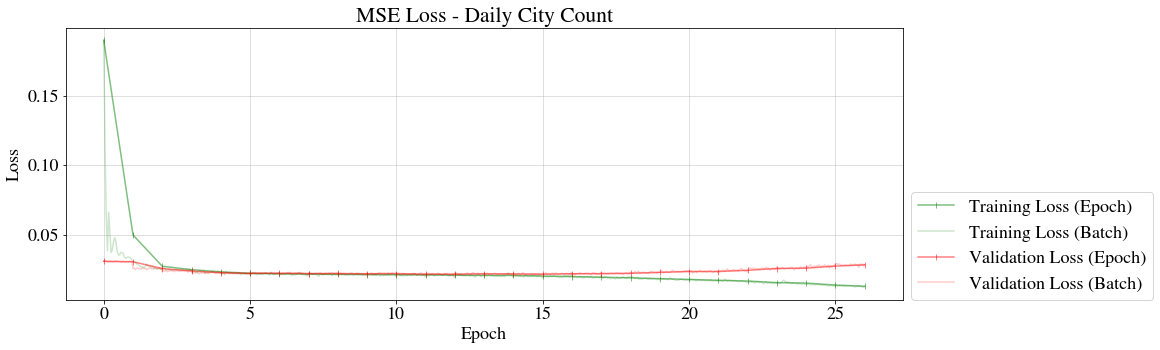

In [62]:
def run_trials(num_trials=10):
    """
    Run a full experiment on GRUFNN model multiple times with different seeds
    Data and hyper parameters must be set before hand.
    This function acts as a closure, i.e. some variables are created outside the scope of the function.
    
    Used to:
        1. Setup data loader with predefined input and target data
        2. Setup model
        3. Train model with a validation set once to determine the num_epochs
        4. Run trials loops:
            4.a. Reset seed
            4.b. Resetup model
            4.c. Train with train_val set for predetermined num_epochs
            4.d. Run evaluations on the model
        5. Return a dataframe with seed and forecast metrics for each trial run
    """
    
    
    trial_metrics_list = []
    
    conf.early_stopping = True
    conf.patience = 10
    conf.min_epochs = 1
    conf.max_epochs = 15000

    conf.lr = best_parameters['lr']
    conf.weight_decay = best_parameters['weight_decay']
    hidden_size = best_parameters['hidden_size'] 
    num_layers = best_parameters['num_layers']
    conf.seq_len = best_parameters['seq_len']
    
    #====================================== can be put into loop as well
    # model setup
    conf.seed = int(time())  # unique seed for each run
    set_system_seed(conf.seed) # should be reset with each model instatiation
    
    loaders = SequenceDataLoaders( # setup data loader 3: run trial
        input_data=input_data,
        target_data=target_data,
        t_range=t_range,
        batch_size=conf.batch_size,
        seq_len=conf.seq_len,
        shuffle=conf.shuffle,
        num_workers=0,
        val_ratio=0.5,
        tst_ratio=tst_ratio,
    )   
    
    model = GRUFNN(
        input_size=input_size,
        hidden_size0=hidden_size, 
        hidden_size1=hidden_size//2, 
        output_size=output_size,
        num_layers=num_layers,
    ).to(conf.device)

    criterion = nn.MSELoss()

    optimiser = torch.optim.AdamW(params=model.parameters(),lr=conf.lr, weight_decay=conf.weight_decay)

    trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
        model=model,
        optimiser=optimiser,
        loaders=loaders,
        train_epoch_fn=train_epoch_for_sequence_model,
        loss_fn=criterion,
        conf=conf,
        verbose=False,
    )

    logging.info(f"best validation: {np.min(val_epoch_losses):.6f} @ epoch: {np.argmin(val_epoch_losses) + 1}")

    # full train-val dataset training 
    conf.max_epochs = np.argmin(val_epoch_losses) + 1 # because of index starting at zero
    #====================================== can be put into loop as well

    for i in range(num_trials):
        logging.info(f"Starting trial {i+1} of {num_trials}.")

        conf.seed = int(time())  # unique seed for each run
        set_system_seed(conf.seed) # should be reset with each model instatiation
        model = GRUFNN(
            input_size=input_size,
            hidden_size0=hidden_size, 
            hidden_size1=hidden_size//2, 
            output_size=output_size,
            num_layers=num_layers,
        ).to(conf.device)

        optimiser = torch.optim.AdamW(params=model.parameters(),lr=conf.lr, weight_decay=conf.weight_decay)

        trn_val_epoch_losses = train_model_final(
            model=model,
            optimiser=optimiser,
            loaders=loaders,
            train_epoch_fn=train_epoch_for_sequence_model,
            loss_fn=criterion,
            conf=conf,
        )

        tst_y_true, tst_y_score = evaluate_sequence_model(model, loaders.test_loader, conf)
        trial_metrics = forecast_metrics(y_true=tst_y_true, y_score=tst_y_score)
        trial_metrics['Seed'] = conf.seed
        trial_metrics_list.append(trial_metrics)
        
        logging.info(f"Completed trial {i+1} of {num_trials}.")
    
    return trial_metrics_list

trial_results = run_trials(num_trials=6)

display (pd.DataFrame(trial_results))

pd.DataFrame(trial_results)[['MASE']].plot(kind='box')
plt.show()

### Setup Model

re-write forward walking training as follows

- model-set with seed

- loaders -> percentage vals should be changed to explicit values

- hyper-opt
- train loop
- train val loop
- evaluation
- save evaluation with dates and model weights
- shift to next
    - train loop
    - train val loop
    - evaluation
    - save evaluation with dates and model weights
- aggregate all evaluation results and list plots


In [ ]:
# set hyper params-> set seed -> set model -> set optimiser


conf.seed = int(time())  # 1607355910

conf.lr = best_parameters['lr']
conf.weight_decay = best_parameters['weight_decay']
hidden_size = best_parameters['hidden_size']
num_layers = best_parameters['num_layers']
conf.seq_len = best_parameters['seq_len']

set_system_seed(conf.seed) # should be reset with each model instatiation
model = GRUFNN(
    input_size=input_size,
    hidden_size0=hidden_size, 
    hidden_size1=hidden_size//2, 
    output_size=output_size,
    num_layers=num_layers,
).to(conf.device)

criterion = nn.MSELoss()

optimiser = torch.optim.AdamW(params=model.parameters(),lr=conf.lr, weight_decay=conf.weight_decay)

2021-01-10T23:46:32 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-10T23:46:32 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'latest',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0010328916706433232,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scale_axis': 1,
 'seed': 1610315186,
 'seq_len': 128,
 'shaper_threshold

2021-01-10T23:46:46 | root | INFO | Epoch: 0018/0500
2021-01-10T23:46:47 | root | INFO | 	Loss (Trn): 		0.02045031
2021-01-10T23:46:47 | root | INFO | 	Loss (Best Trn): 	0.02045031
2021-01-10T23:46:47 | root | INFO | 	Loss (Val): 		0.02196521
2021-01-10T23:46:47 | root | INFO | 	Loss (Best Val): 	0.02188809
2021-01-10T23:46:47 | root | INFO | 	Loss (Trn Val Dif): 	0.00151490

2021-01-10T23:46:47 | root | INFO | Epoch: 0019/0500
2021-01-10T23:46:48 | root | INFO | 	Loss (Trn): 		0.02045405
2021-01-10T23:46:48 | root | INFO | 	Loss (Best Trn): 	0.02045031
2021-01-10T23:46:48 | root | INFO | 	Loss (Val): 		0.02218109
2021-01-10T23:46:48 | root | INFO | 	Loss (Best Val): 	0.02188809
2021-01-10T23:46:48 | root | INFO | 	Loss (Trn Val Dif): 	0.00172705

2021-01-10T23:46:48 | root | INFO | Epoch: 0020/0500
2021-01-10T23:46:48 | root | INFO | 	Loss (Trn): 		0.02016607
2021-01-10T23:46:48 | root | INFO | 	Loss (Best Trn): 	0.02016607
2021-01-10T23:46:48 | root | INFO | 	Loss (Val): 		0.02197450

2021-01-10T23:47:04 | root | INFO | 	Loss (Best Val): 	0.02188809
2021-01-10T23:47:04 | root | INFO | 	Loss (Trn Val Dif): 	0.02376707

2021-01-10T23:47:04 | root | INFO | Epoch: 0040/0500
2021-01-10T23:47:05 | root | INFO | 	Loss (Trn): 		0.00902876
2021-01-10T23:47:05 | root | INFO | 	Loss (Best Trn): 	0.00902876
2021-01-10T23:47:05 | root | INFO | 	Loss (Val): 		0.03556813
2021-01-10T23:47:05 | root | INFO | 	Loss (Best Val): 	0.02188809
2021-01-10T23:47:05 | root | INFO | 	Loss (Trn Val Dif): 	0.02653936

2021-01-10T23:47:05 | root | INFO | Epoch: 0041/0500
2021-01-10T23:47:06 | root | INFO | 	Loss (Trn): 		0.00830171
2021-01-10T23:47:06 | root | INFO | 	Loss (Best Trn): 	0.00830171
2021-01-10T23:47:06 | root | INFO | 	Loss (Val): 		0.03599237
2021-01-10T23:47:06 | root | INFO | 	Loss (Best Val): 	0.02188809
2021-01-10T23:47:06 | root | INFO | 	Loss (Trn Val Dif): 	0.02769066

2021-01-10T23:47:06 | root | INFO | Epoch: 0042/0500
2021-01-10T23:47:07 | root | INFO | 	Loss (Trn): 		0.

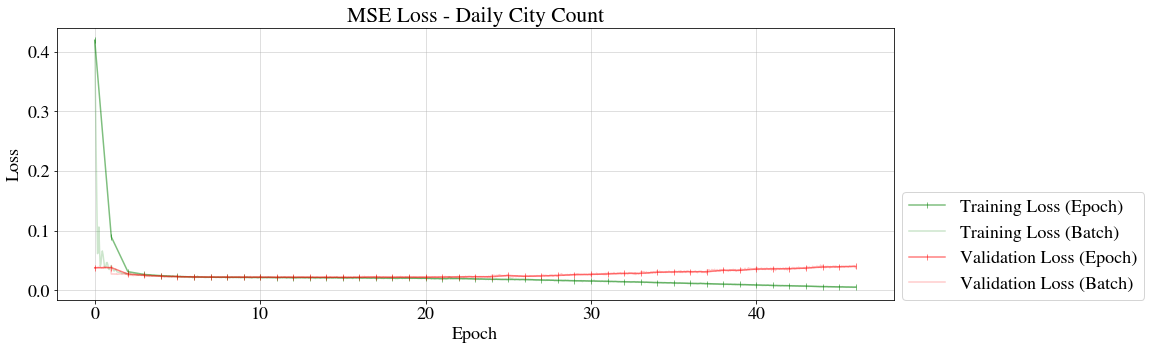

In [70]:
# train model with early stopping -> get max epochs for train validation set

conf.resume = False
conf.checkpoint = "final" #"latest" # ["best_val", "best_trn", "best_trn_val"]
conf.early_stopping = True
conf.patience = 30
conf.min_epochs = 1
conf.max_epochs = 15000

trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
    model=model,
    optimiser=optimiser,
    loaders=loaders,
    train_epoch_fn=train_epoch_for_sequence_model,
    loss_fn=criterion,
    conf=conf,
)

In [71]:
logging.info(f"best validation: {np.min(val_epoch_losses):.6f} @ epoch: {np.argmin(val_epoch_losses) + 1}")

2021-01-10T23:47:16 | root | INFO | best validation: 0.021888 @ epoch: 15


In [72]:
# plot train and validation sets

from utils.interactive import plot_interactive_epoch_losses
fig = plot_interactive_epoch_losses(trn_epoch_losses, val_epoch_losses)
fig.write_image(f"{save_folder}{FREQ}_loss_val_plot.png")
fig.show()

In [73]:
# set max epochs -> reset to same seed as before -> recreate model -> recreate optimiser -> train final model

conf.max_epochs = np.argmin(val_epoch_losses) + 1 # because of index starting at zero

set_system_seed(conf.seed) # should be reset with each model instatiation
model = GRUFNN(
    input_size=input_size,
    hidden_size0=hidden_size, 
    hidden_size1=hidden_size//2, 
    output_size=output_size,
    num_layers=num_layers,
).to(conf.device)

optimiser = torch.optim.AdamW(params=model.parameters(),lr=conf.lr, weight_decay=conf.weight_decay)

trn_val_epoch_losses = train_model_final(
    model=model,
    optimiser=optimiser,
    loaders=loaders,
    train_epoch_fn=train_epoch_for_sequence_model,
    loss_fn=criterion,
    conf=conf,
)

plot(trn_val_epoch_losses=trn_val_epoch_losses)

2021-01-10T23:47:28 | root | INFO | Set system seed to 1610315186
2021-01-10T23:47:28 | root | INFO | 
 ====================== Final Training Daily City Count ====================== 

2021-01-10T23:47:28 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'latest',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0010328916706433232,
 'max_epochs': 15,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 's

#### Training Results

In [74]:
# Load latest or best validation or final model
# conf.checkpoint = "latest"
# conf.checkpoint = "best_val"
# conf.checkpoint = "best_trn"
conf.checkpoint = "final" # train and validation set trained model

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
log.info(f"loading model from {conf.model_path}")
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth", map_location=conf.device.type)
model.load_state_dict(model_state_dict)

2021-01-10T23:47:50 | root | INFO | Loading model from checkpoint (final) for evaluation
2021-01-10T23:47:50 | root | INFO | loading model from ./data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily City Count/


<All keys matched successfully>

In [75]:
if FREQ == '1H':
    step=24
    max_steps=14
elif FREQ == '24H':
    step=7
    max_steps=6
elif FREQ == '168H':
    step=52
    max_steps=3

In [76]:
from sklearn.metrics import mean_absolute_error
class EWM:
    def __init__(self, series=None):
        self.alpha = .9
        self.options = np.arange(0.001,0.999,0.001)
        
        if series is not None:
            self.fit(series)
            
    def __call__(self, series):
        return self.predict(series)
        
    def fit(self, series):
        losses = []
        for alpha in self.options:
            self.alpha = alpha
            pred = self.predict(series)
            loss = mean_absolute_error(series, pred)
            losses.append(loss)
            
        self.alpha = self.options[np.argmin(losses)]
#         print(f"alpha => {self.alpha}")
    
    def predict(self, series):
        series = np.pad(series, (1,0), 'edge')
        
        pred = pd.Series(series).ewm(alpha=self.alpha).mean().values[:-1]
        return pred

In [77]:
from pandas import DataFrame

def compare_time_series_metrics(
    y_true, 
    y_score, 
    t_range,
    feature_names, 
    is_training_set,
    step=24, 
    max_steps=29,
    alpha=0.5, 
    rangeslider_visible=True,
):
    kwargs = dict()

    offset = step * max_steps

    assert len(y_true.shape) == 2
    
    
    model_name_dict = {}
    feature_results = {}
    
    if is_training_set:
        training_str = "(Training Data)"
    else:
        training_str = "(Test Data)"
    
     
    for i, feat_name in enumerate(feature_names):
        kwargs[f"{feat_name}_y_score"] = y_score[offset:, i]
        kwargs[f"{feat_name}_y_true"] = y_true[offset:, i]
        kwargs[f"{feat_name}_y_ha"] = historic_average(y_true[:, i], step=step,
                                                       max_steps=max_steps)[offset - 1:-1]    
        
        ewm = EWM(y_true[:,i])
        kwargs[f"{feat_name}_y_ewm"] = ewm(y_true[:,i])[offset:]
        
        feature_results[feat_name] = {
            "Ground Truth": y_true[offset:, i],
            "GRUFNN": y_score[offset:, i],
            f"HA({step},{max_steps})": historic_average(y_true[:, i],
                                                  step=step,max_steps=max_steps)[offset - 1:-1],
            f"EWM({ewm.alpha:.3f})": ewm(y_true[:,i])[offset:],
        }

        model_name_dict[feat_name] = {
            "y_score": "GRUFNN",
            "y_true": "Ground Truth",
            "y_ha": f"HA({step},{max_steps})",
            "y_ewm": f"EWM({ewm.alpha:.3f})",
        }
        
        fig = plot_time_signals(
            t_range=t_range[offset:], 
            alpha=alpha,
            title=f'{freq_title} {feat_name.title()} Predicted Normalised City Counts {training_str}',
            ylabel='Normalised Counts [0,1]',
            xlabel='Date',
            rangeslider_visible=rangeslider_visible,
            **feature_results[feat_name]
        )

        fig.write_image(f"{save_folder}{FREQ}_{feat_name}_predictions_{training_str}.png")
        fig.show()

    ll = [] # {}
    for k, v in kwargs.items():
        i = k.find("_")
        feat_name = k[:i]
        model_type = k[i+1:]
        if model_type == 'y_true':
            continue
        row = {}
        crime_type_name = feat_name.title()
        model_name = model_name_dict[feat_name][model_type]
        row['Crime Type'] = crime_type_name
        row['Model'] = model_name
        row_ = forecast_metrics(y_true=kwargs[f"{feat_name}_y_true"], y_score=kwargs[k])
        row = {**row, **row_}
        
        ll.append(row)

#     plot_time_signals(t_range=t_range[offset:], alpha=alpha,
#                       title=f'{freq_title} Predicted Normalised City Counts',
#                       yaxis_title='Normalised Counts [0,1]',**kwargs).show()

    metrics = DataFrame(ll)
    metrics.sort_values(['Crime Type','MASE'],inplace=True)
    metrics.reset_index(inplace=True, drop='index')

    return metrics

In [78]:
from utils.utils import write_txt
metrics_folder = f"./data/processed/{data_sub_path}/metrics/"
os.makedirs(metrics_folder, exist_ok=True)

In [79]:
trn_y_true, trn_y_score = evaluate_sequence_model(model, loaders.train_loader, conf)

# trn_y_score = scaler.inverse_transform(trn_y_score)
# trn_y_true = scaler.inverse_transform(trn_y_true)

trn_metrics = compare_time_series_metrics(
    y_true=trn_y_true,
    y_score=trn_y_score,
    t_range=loaders.train_loader.dataset.t_range[-len(trn_y_true):],
    feature_names=list(total_df.columns[:trn_y_true.shape[1]]),#feature_names[:trn_y_true.shape[1]],
    step=step,
    max_steps=max_steps,
    is_training_set=True,
    rangeslider_visible=False,
)
display(trn_metrics)

trn_metrics_latex = trn_metrics.round(decimals=3).to_latex(
    index=False,
    caption=f"{freq_title} Crime Count Forecasting Metrics (Training Data)",
    label="tab:daily-crime-count-metrics",
)

pd.to_pickle(trn_metrics, f"{metrics_folder}{FREQ}_metrics_train.pkl")
write_txt(trn_metrics_latex, f"{metrics_folder}{FREQ}_metrics_train_latex.txt")

Crime Type       Model      MASE       MAE       MSE      RMSE
0      Total      GRUFNN  0.756471  0.108561  0.018937  0.137613
1      Total  EWM(0.219)  0.860257  0.123448  0.024748  0.157315
2      Total     HA(7,6)  1.021125  0.146580  0.033561  0.183198

#### Best Test Results (1H)  `(best 0.700818)`
```python
hidden_size = 20
epochs = 4
seq_len = 168
batch_size = 128
lr = 1-e2
seed = 1606470692
num_layer=1


GRUFNN(
  (gru): GRU(18, 20, batch_first=True)
  (lin1): Linear(in_features=20, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
  (activation): RReLU(lower=0.01, upper=0.1)
)

model = GRUFNN(
    input_size=input_size,
    hidden_size0=hidden_size, 
    hidden_size1=hidden_size//2, 
    output_size=1, 
    num_layers=2,
)
```

#### Best Test Results (24H)  `(best 0.814835)`
```python
val_ratio = 0.25
tst_ratio = 0.25
hidden_size = 100
epochs = 15
seq_len = 90
batch_size = 128
lr = 1-e2
seed = 1607355910
num_layer=2

GRUFNN(
  (gru): GRU(16, 100, num_layers=2, batch_first=True)
  (lin1): Linear(in_features=100, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=1, bias=True)
  (activation): RReLU(lower=0.01, upper=0.1)
)
```



In [80]:
tst_y_true, tst_y_score = evaluate_sequence_model(model, loaders.test_loader, conf)
# tst_y_true, tst_y_score = tst_y_true[:,0], tst_y_score[:,0] 

tst_metrics = compare_time_series_metrics(
    y_true=tst_y_true, 
    y_score=tst_y_score,
    t_range=loaders.test_loader.dataset.t_range[-len(tst_y_true):],
#     feature_names=feature_names[:tst_y_true.shape[1]],
    feature_names=list(total_df.columns[:tst_y_true.shape[1]]),
    is_training_set=False,
    step=step,
    max_steps=max_steps,
    rangeslider_visible=False,
)

display(tst_metrics)

tst_metrics_latex = tst_metrics.round(decimals=3).to_latex(
    index=False,
    caption=f"{freq_title} Crime Count Forecasting Metrics (Test Data)",
    label="tab:daily-crime-count-metrics",
)

pd.to_pickle(tst_metrics, f"{metrics_folder}{FREQ}_metrics_test.pkl")
write_txt(tst_metrics_latex, f"{metrics_folder}{FREQ}_metrics_test.txt")

Crime Type       Model      MASE       MAE       MSE      RMSE
0      Total      GRUFNN  0.841351  0.111381  0.019770  0.140605
1      Total  EWM(0.326)  0.849066  0.112589  0.020810  0.144255
2      Total     HA(7,6)  1.037868  0.137467  0.028475  0.168745

In [81]:
from pandas.io import clipboard
clipboard.copy(f'''
<html>
<center> <h4>(seed: {conf.seed}, epochs: {conf.max_epochs}, num_layers: {num_layers}, hidden_size: {hidden_size}, lr: {conf.lr}, wd: {conf.weight_decay})</h4> </center>   
{tst_metrics.to_html()}
</html>
''')


<html>
<center> <h4>(seed: 1610315186, epochs: 15, num_layers: 4, hidden_size: 128, lr: 0.0010328916706433232, wd: 9.688212788780198e-07)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.841351</td>
      <td>0.111381</td>
      <td>0.019770</td>
      <td>0.140605</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>EWM(0.326)</td>
      <td>0.849066</td>
      <td>0.112589</td>
      <td>0.020810</td>
      <td>0.144255</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.037868</td>
      <td>0.137467</td>
      <td>0.028475</td>
      <td>0.168745</td>
    </tr>
  </tbody>
</table>
</html>

<html>
<center> <h4>(seed: 1609928999, epochs: 27, num_layers: 1, hidden_size: 64, lr: 0.0014512428545394168, wd: 1.1569041471744064e-05)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.852752</td>
      <td>0.119475</td>
      <td>0.022752</td>
      <td>0.150838</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>EWM(0.332)</td>
      <td>0.865785</td>
      <td>0.121262</td>
      <td>0.023223</td>
      <td>0.152391</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.058839</td>
      <td>0.148276</td>
      <td>0.033438</td>
      <td>0.182861</td>
    </tr>
  </tbody>
</table>
</html>


<html>
<center> <h4>(seed: 1609928653, epochs: 15, num_layers: 1, hidden_size: 64, lr: 0.0014512428545394168, wd: 1.1569041471744064e-05)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.839292</td>
      <td>0.117585</td>
      <td>0.021612</td>
      <td>0.147011</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>EWM(0.332)</td>
      <td>0.865785</td>
      <td>0.121262</td>
      <td>0.023223</td>
      <td>0.152391</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.058839</td>
      <td>0.148276</td>
      <td>0.033438</td>
      <td>0.182861</td>
    </tr>
  </tbody>
</table>
</html>


### 100 nodes @ 2 layers

<html>
<center> <h4>Seed Test Metrics (seed: 232323)</h4> </center>   
    
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>1.036609</td>
      <td>0.032579</td>
      <td>0.001614</td>
      <td>0.040180</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>

</html>

<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 15)</h4> </center>   
   

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.892761</td>
      <td>0.028061</td>
      <td>0.001242</td>
      <td>0.035237</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
    
</html>
    
    

<html>
<center> <h4>Seed Test Metrics (seed: 1609862642, epochs: 25)</h4> </center>   
 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.996154</td>
      <td>0.031305</td>
      <td>0.001518</td>
      <td>0.038966</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>

  

### 8 nodes @ 2 layers

<html>
<center> <h4>Seed Test Metrics (seed: 1609863699, epochs: 60)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.930785</td>
      <td>0.029265</td>
      <td>0.001306</td>
      <td>0.036135</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 44)</h4> </center>   
 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.868942</td>
      <td>0.027309</td>
      <td>0.001180</td>
      <td>0.034354</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


<html>
<center> <h4>Seed Test Metrics (seed: 1609863699, epochs: 30)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.918288</td>
      <td>0.028870</td>
      <td>0.001323</td>
      <td>0.036370</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


### 8 nodes @ 1 layer

<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 106)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.916288</td>
      <td>0.028808</td>
      <td>0.001348</td>
      <td>0.036717</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>



<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 17)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.952805</td>
      <td>0.029954</td>
      <td>0.001456</td>
      <td>0.038160</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


<html>
<center> <h4>Seed Test Metrics (seed: 1609864074, epochs: 50)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.917947</td>
      <td>0.028868</td>
      <td>0.001355</td>
      <td>0.036804</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


### 16 nodes @ 2 layer


<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 110)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.880144</td>
      <td>0.027685</td>
      <td>0.001247</td>
      <td>0.035309</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.996154</td>
      <td>0.031305</td>
      <td>0.001518</td>
      <td>0.038966</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>

In [35]:
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())
else:
    raise Exception("CUDA is not available")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     849 KB |  365417 KB |    2693 GB |    2693 GB |
|       from large pool |       0 KB |  354912 KB |    2079 GB |    2079 GB |
|       from small pool |     849 KB |   10505 KB |     613 GB |     613 GB |
|---------------------------------------------------------------------------|
| Active memory         |     849 KB |  365417 KB |    2693 GB |    2693 GB |
|       from large pool |       0 KB |  354912 KB |    2079 GB |

## Residual Sequence Model

In [36]:
# time series normalisation 
